In [9]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime as dt
import random
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt

In [10]:
START = dt.datetime(2001, 11, 1)
END = dt.datetime(2022, 11, 30)
random.seed(61)

In [11]:
table = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

# Individual stock list in S&P500
stock_list = table[0].iloc[:, 0].to_list()
stock_list = random.sample(stock_list, 25)  # Randomly select 25 stocks

df = web.DataReader(stock_list, 'yahoo', START, END)['Close']

df = df.asfreq('M', method='pad')  # Transfor monthly frequency
df = np.log(df).diff(1).iloc[1:]  # Stationarize the data
df.dropna(axis=1, inplace=True)

lag_df = df.shift(1)  # Lagged data
df = df.iloc[12:]
lag_df = lag_df.iloc[12:]


In [12]:
# Fit the DFM
model = sm.DynamicFactor(endog=df, exog=lag_df, k_factors=3,
                         factor_order=2, error_order=1)
results = model.fit(maxiter=500, disp=False)

/opt/anaconda3/envs/memenv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
forecast = results.forecast(steps=1, exog=df.iloc[-1:, :])
forecast

,CAT,CINF,SRE,UNH,ETN,SLB,OMC,APD,ITW,AIG,HD,EW,YUM,CPT,LLY,MDLZ,USB,INTU,OXY
2022-12-31,0.044318,-0.001404,0.017059,0.020042,0.058065,0.119347,0.04432,0.021298,0.046336,0.349478,0.013815,0.018349,0.052171,0.083519,-0.016742,0.022108,0.067752,0.041922,0.070701


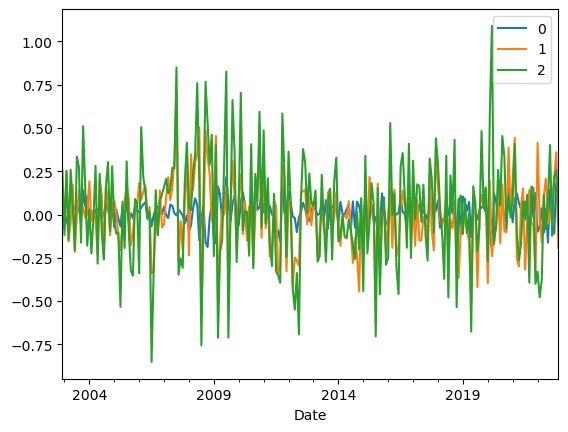

In [14]:
pd.DataFrame(results.factors.smoothed.T, index=df.index).plot()
plt.show()

In [15]:
print(results.summary())

                                                                                     Statespace Model Results                                                                                     
Dep. Variable:     ['CAT', 'CINF', 'SRE', 'UNH', 'ETN', 'SLB', 'OMC', 'APD', 'ITW', 'AIG', 'HD', 'EW', 'YUM', 'CPT', 'LLY', 'MDLZ', 'USB', 'INTU', 'OXY']   No. Observations:                  240
Model:                                                                                                                  DynamicFactor(factors=3, order=2)   Log Likelihood                5282.239
                                                                                                                                          + 19 regressors   AIC                          -9616.478
                                                                                                                                           + AR(1) errors   BIC                          -7966.655
Date:                    